# Chronic Kidney Disease (CKD) Prediction Project

Chronic kidney disease is a growing global health concern that can lead to serious complications such as dialysis and kidney failure if not managed early. In this project, I use clinical and laboratory features to predict two key outcomes: whether a patient has CKD, and whether they are likely to require dialysis in the future. These insights can support early detection and targeted interventions.

## Project Overview

This project aims to model the progression of chronic kidney disease (CKD) using a synthetic but clinically realistic dataset. I build two binary classification models to predict:
- **CKD_Status**: Does the patient have CKD?
- **Dialysis_Needed**: Is the patient likely to require dialysis?

I train and evaluate multiple machine learning models using cross-validation and assess performance on a held-out test set.

The dataset I use comes from [this Kaggle source](https://www.kaggle.com/datasets/miadul/kidney-disease-risk-dataset).

---

### Notebook Structure

The notebook is structured in **two main parts**, each targeting a different binary classification task:


#### 🔹 Part 1 — CKD Status Prediction (`CKD_Status`)
- Data Loading, Cleaning and Overview
- Exploratory Data Analysis (EDA)
- Class Imbalance Analysis
- Model Training and Cross-Validation (C.V.)
- Model Evaluation on the Test Set
- Conclusion & Key Findings



#### 🔹 Part 2 — Dialysis Need Prediction (`Dialysis_Needed`)
- Exploratory Data Analysis (EDA)
- Class Imbalance Analysis
- Model Training and Cross-Validation (C.V.)
- Model Evaluation on the Test Set
- Conclusion & Key Findings


---

### Feature Dictionary

Below is a clinical explanation of each feature used in this project.

| Feature            | Type        | Description |
|--------------------|-------------|-------------|
| **Age**            | Numeric     | Patient's age in years. Risk increases with age. |
| **Creatinine_Level** | Numeric   | Blood creatinine (mg/dL). Elevated levels indicate impaired kidney filtration. |
| **BUN**            | Numeric     | Blood Urea Nitrogen (mg/dL). High levels may indicate CKD or dehydration. |
| **Diabetes**       | Categorical | 1 = Patient has diabetes, 0 = No. Diabetes is a major CKD risk factor. |
| **Hypertension**   | Categorical | 1 = Patient has high blood pressure, 0 = No. Often associated with kidney issues. |
| **GFR**            | Numeric     | Glomerular Filtration Rate (ml/min/1.73m²). The most accurate measure of kidney function. |
| **Urine_Output**   | Numeric     | Daily urine volume (ml/day). Low output is a potential indicator of kidney dysfunction. |
| **CKD_Status**     | Target      | 1 = CKD present, 0 = No CKD. This is the variable to predict. |



---
## Library Imports

In [1]:
# Data Manipulation & Analysis
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Testing
from scipy.stats import f_oneway

# Preprocessing & Utilities
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
import joblib

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


---

## Data Loading, Cleaning and Overview

In this section, I import the dataset, perform a basic inspection, and check for initial data quality before proceeding with further analysis.

The dataset contains 2,304 entries and 9 columns, with no missing values. All features are numerical and already in the correct format for analysis, so no immediate type conversion or imputation is required.


In [3]:
df = pd.read_csv('./dataset/kidney_disease_dataset.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               2304 non-null   int64  
 1   Creatinine_Level  2304 non-null   float64
 2   BUN               2304 non-null   float64
 3   Diabetes          2304 non-null   int64  
 4   Hypertension      2304 non-null   int64  
 5   GFR               2304 non-null   float64
 6   Urine_Output      2304 non-null   float64
 7   CKD_Status        2304 non-null   int64  
 8   Dialysis_Needed   2304 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 162.1 KB


In [6]:
df.head()

,Age,Creatinine_Level,BUN,Diabetes,Hypertension,GFR,Urine_Output,CKD_Status,Dialysis_Needed
0,71,0.30,40.9,0,1,46.8,1622.0,1,0
1,34,1.79,17.1,0,0,43.8,1428.0,1,0
2,80,2.67,15.0,0,1,78.2,1015.0,1,0
3,40,0.97,31.1,0,1,92.8,1276.0,1,0
4,43,2.05,22.8,1,1,62.2,1154.0,0,0


In [7]:
df.describe()

,Age,Creatinine_Level,BUN,Diabetes,Hypertension,GFR,Urine_Output,CKD_Status,Dialysis_Needed
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,54.159288,1.305638,18.813672,0.406684,0.498264,68.953863,1309.189670,0.508681,0.013455
std,20.513729,0.789594,10.508358,0.491322,0.500106,24.660191,491.951914,0.500033,0.115237
min,20.000000,0.300000,5.000000,0.000000,0.000000,5.000000,100.000000,0.000000,0.000000
25%,36.000000,0.620000,9.975000,0.000000,0.000000,51.300000,967.750000,0.000000,0.000000
50%,54.000000,1.240000,18.200000,0.000000,0.000000,69.150000,1295.500000,1.000000,0.000000
75%,72.000000,1.842500,26.000000,1.000000,1.000000,86.300000,1633.500000,1.000000,0.000000
max,90.000000,4.130000,61.900000,1.000000,1.000000,120.000000,2899.000000,1.000000,1.000000


In [8]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

---
## 🔹 Part 1 — CKD Status Prediction (`CKD_Status`)

### Exploratory Data Analysis (EDA)

We explore feature distributions and their relationship to the target variable **CKD_Status** (0 = No CKD, 1 = CKD) using histograms with KDE overlays. This helps uncover patterns and potential predictive power of each feature.


---

#### Feature Distributions by CKD_Status


##### Age Distribution by CKD_Status

This histogram shows how **age** is distributed across patients with and without CKD:

- **Class 0 (No CKD)**: The age distribution is relatively uniform across adults, with slight peaks around 40 and 70 years old.
- **Class 1 (CKD)**: Slightly more frequent among older patients, with a visible presence starting from age **50+**.

➡️ Age shows **moderate class separation**, with CKD cases appearing more in older individuals, consistent with known risk factors.



##### Creatinine Level Distribution

- **Class 0 (No CKD)**: Most creatinine levels are concentrated under **2.0 mg/dL**, reflecting normal kidney function.
- **Class 1 (CKD)**: The distribution skews significantly to the right, with many patients having elevated creatinine levels, often above **2.5 mg/dL**.

➡️ This strong difference highlights **Creatinine Level as a key feature** for CKD prediction, consistent with its clinical significance as a marker of kidney function.


##### BUN (Blood Urea Nitrogen) Distribution

- **Class 0 (No CKD)**: The distribution is left-skewed, with most patients under **25 mg/dL**.
- **Class 1 (CKD)**: BUN levels shift to the right, with several cases exceeding **30–40 mg/dL**.

➡️ BUN appears to be another **reliable indicator of CKD**, as high values are rarely observed in non-CKD individuals.


##### GFR (Glomerular Filtration Rate) Distribution

- **Class 0 (No CKD)**: GFR is normally distributed around **80–100 mL/min/1.73m²**, which is considered healthy.
- **Class 1 (CKD)**: GFR values are significantly lower, clustering around **40–60**, with very few patients above 70.

➡️ As expected, **low GFR is a strong predictor** of CKD. This matches medical definitions, where GFR < 60 indicates possible kidney dysfunction.



##### Urine Output Distribution

- **Class 0 (No CKD)** and **Class 1 (CKD)**: Both classes follow a relatively normal distribution centered around **1300–1500 mL/day**.
- There is substantial overlap between the two distributions, with no strong skew in either direction.

➡️ While urine output may hold some value in extreme cases, it shows **limited discriminatory power** on its own compared to other features like GFR or Creatinine.

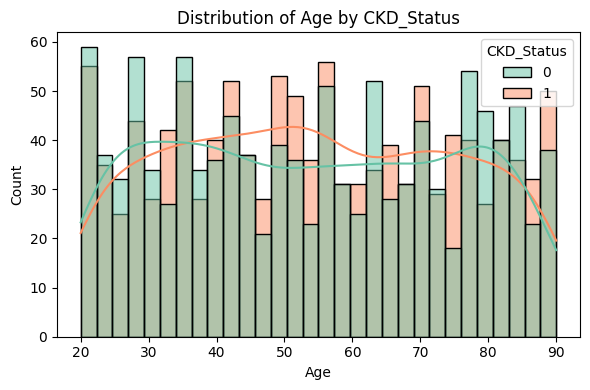

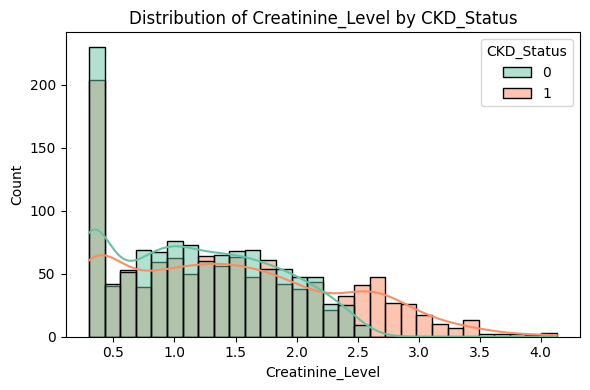

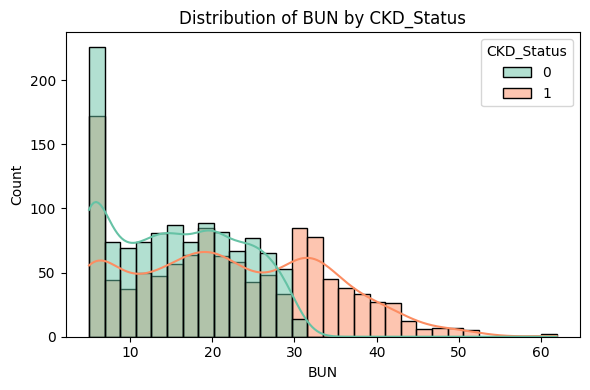

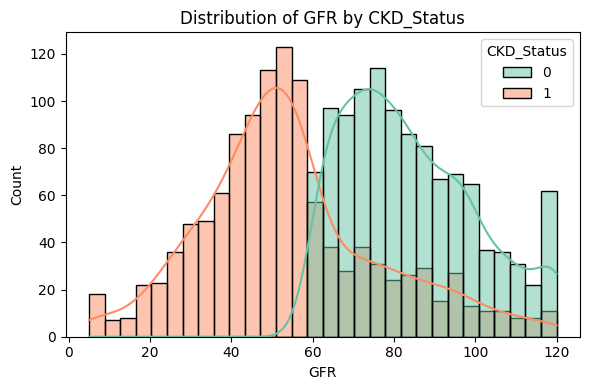

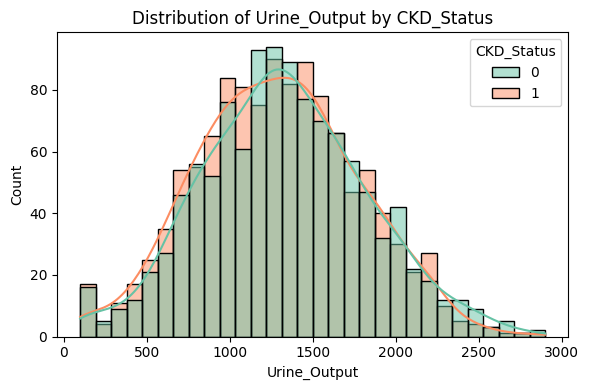

In [8]:
features = ["Age", "Creatinine_Level", "BUN", "GFR", "Urine_Output"]

for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, hue="CKD_Status", kde=True, palette="Set2", bins=30)
    plt.title(f"Distribution of {col} by CKD_Status")
    plt.tight_layout()
    plt.show()

#### Boxplot Comparison by CKD_Status

We use boxplots to complement the previous KDE histograms and **visualize the spread, median, and potential outliers** of each numerical feature across CKD classes.

##### Age by CKD_Status

This boxplot shows a similar spread of age between the two groups:

- **Class 0 (No CKD)** and **Class 1 (CKD)** both have a median age around **55 years**.
- The distributions have comparable ranges, with slightly more outliers in the upper age range.

➡️ While **age alone may not be strongly discriminatory**, it remains a relevant factor, especially in combination with other features like GFR and creatinine.


##### Creatinine Level by CKD_Status

- **No CKD**: Median around **1.1 mg/dL**, with an upper bound around 2.5.
- **CKD**: Wider spread and higher median (~1.5 mg/dL), with several extreme outliers above 4.

➡️ This again reinforces the idea that **Creatinine Level is a crucial differentiator** in CKD prediction, with a clearly elevated range among CKD patients.


##### BUN by CKD_Status

- **No CKD**: Tight distribution, with most patients below **25 mg/dL**.
- **CKD**: Larger spread and more high-end outliers (some above **60 mg/dL**).

➡️ The **higher BUN values and presence of extreme outliers** in the CKD group suggest this feature is predictive, especially for more severe cases.


##### GFR by CKD_Status

- **No CKD**: GFR centered around **80–90**, with little variance.
- **CKD**: Median is sharply lower (~55), and more values are concentrated under **60**.

➡️ This strong shift downward in GFR for CKD patients matches clinical guidelines — confirming **GFR < 60** is a key threshold in diagnosis.


##### Urine Output by CKD_Status

- Both classes show similar distributions around **1300–1500 mL/day**, with some outliers.
- No significant shift in median or spread.

➡️ While **urine output may highlight abnormal extremes**, its central tendency appears similar across classes — making it **less useful alone** for binary classification.


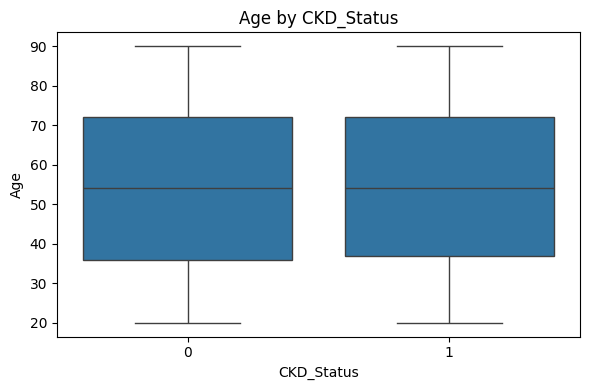

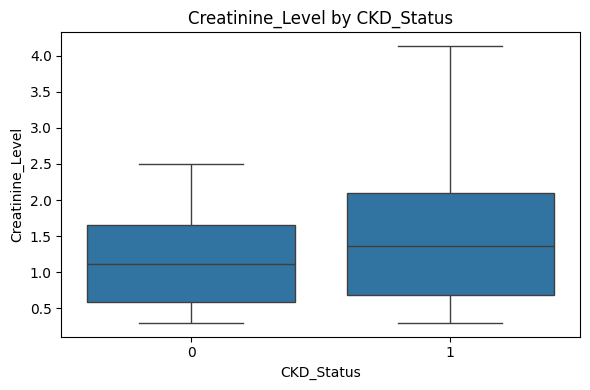

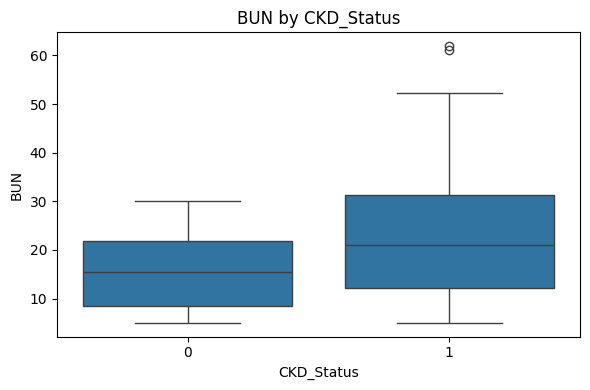

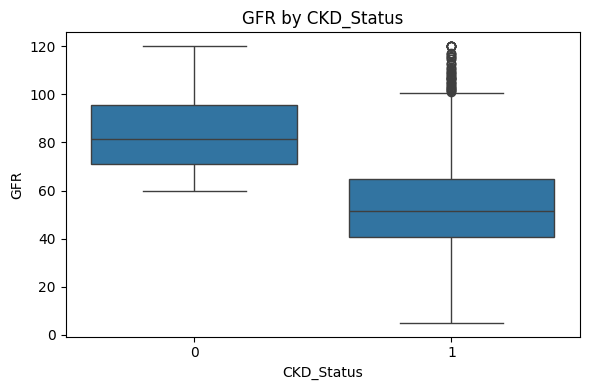

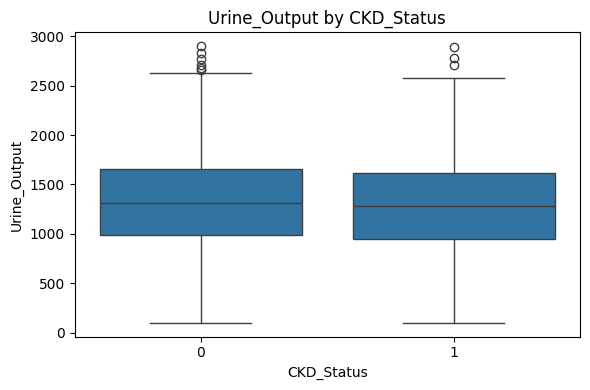

In [9]:
for col in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="CKD_Status", y=col, data=df)
    plt.title(f"{col} by CKD_Status")
    plt.tight_layout()
    plt.show()

#### Correlation Heatmap Insights

This heatmap displays **Pearson correlation coefficients** between all numeric and binary variables, with only the **lower triangle shown** to reduce redundancy and improve readability.

##### Key takeaways:

- **CKD_Status** has strong correlation patterns:
  - Positively correlated with **BUN** (**r = 0.31**) and **Creatinine_Level** (**r = 0.19**), both indicative of impaired kidney function.
  - Strong **negative correlation with GFR** (**r = -0.60**), reflecting how lower filtration rate is a hallmark of CKD diagnosis.
- **Dialysis_Needed** shows a moderate positive correlation with **CKD_Status** (**r = 0.11**) and a mild negative correlation with **GFR** (**r = -0.29**).
- Other features like **Age**, **Urine_Output**, **Diabetes**, and **Hypertension** exhibit low correlation with both target variables, suggesting limited linear association.

➡️ These insights are consistent with clinical expectations and reinforce earlier findings from **EDA** and **ANOVA**, further validating the **predictive value** of Creatinine, BUN, and GFR for CKD progression.

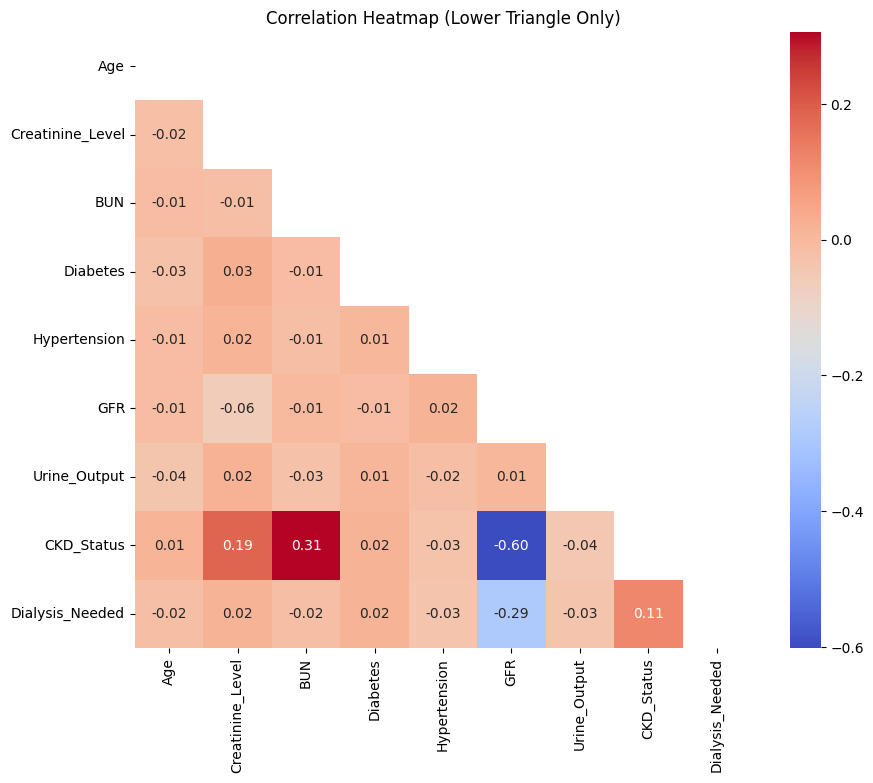

In [12]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Lower Triangle Only)")
plt.show()

#### Pairwise Feature Relationships by CKD_Status

The following pairplot visualizes **pairwise relationships between key numerical features**, color-coded by `CKD_Status`:

- **Diagonal plots** show the distribution of each feature for CKD (orange) and non-CKD (blue) patients.
- **Scatterplots below the diagonal** illustrate correlations between feature pairs and how they cluster by CKD class.

##### Key Observations:

- **GFR vs. Creatinine / BUN**: There is a clear **negative relationship** — CKD patients tend to have **lower GFR** and **higher Creatinine/BUN**, as expected clinically.
- **GFR distribution** shows strong separation between classes, making it a highly predictive feature.
- **Creatinine_Level and BUN**: Both show right-skewed distributions for CKD patients, reinforcing their importance.
- **Urine_Output and Age**: Show little to no class separation, indicating **limited discriminative power** on their own.

➡️ This visualization confirms that **GFR, Creatinine_Level, and BUN** are the most informative features for distinguishing CKD status, and reveals feature interactions useful for modeling.

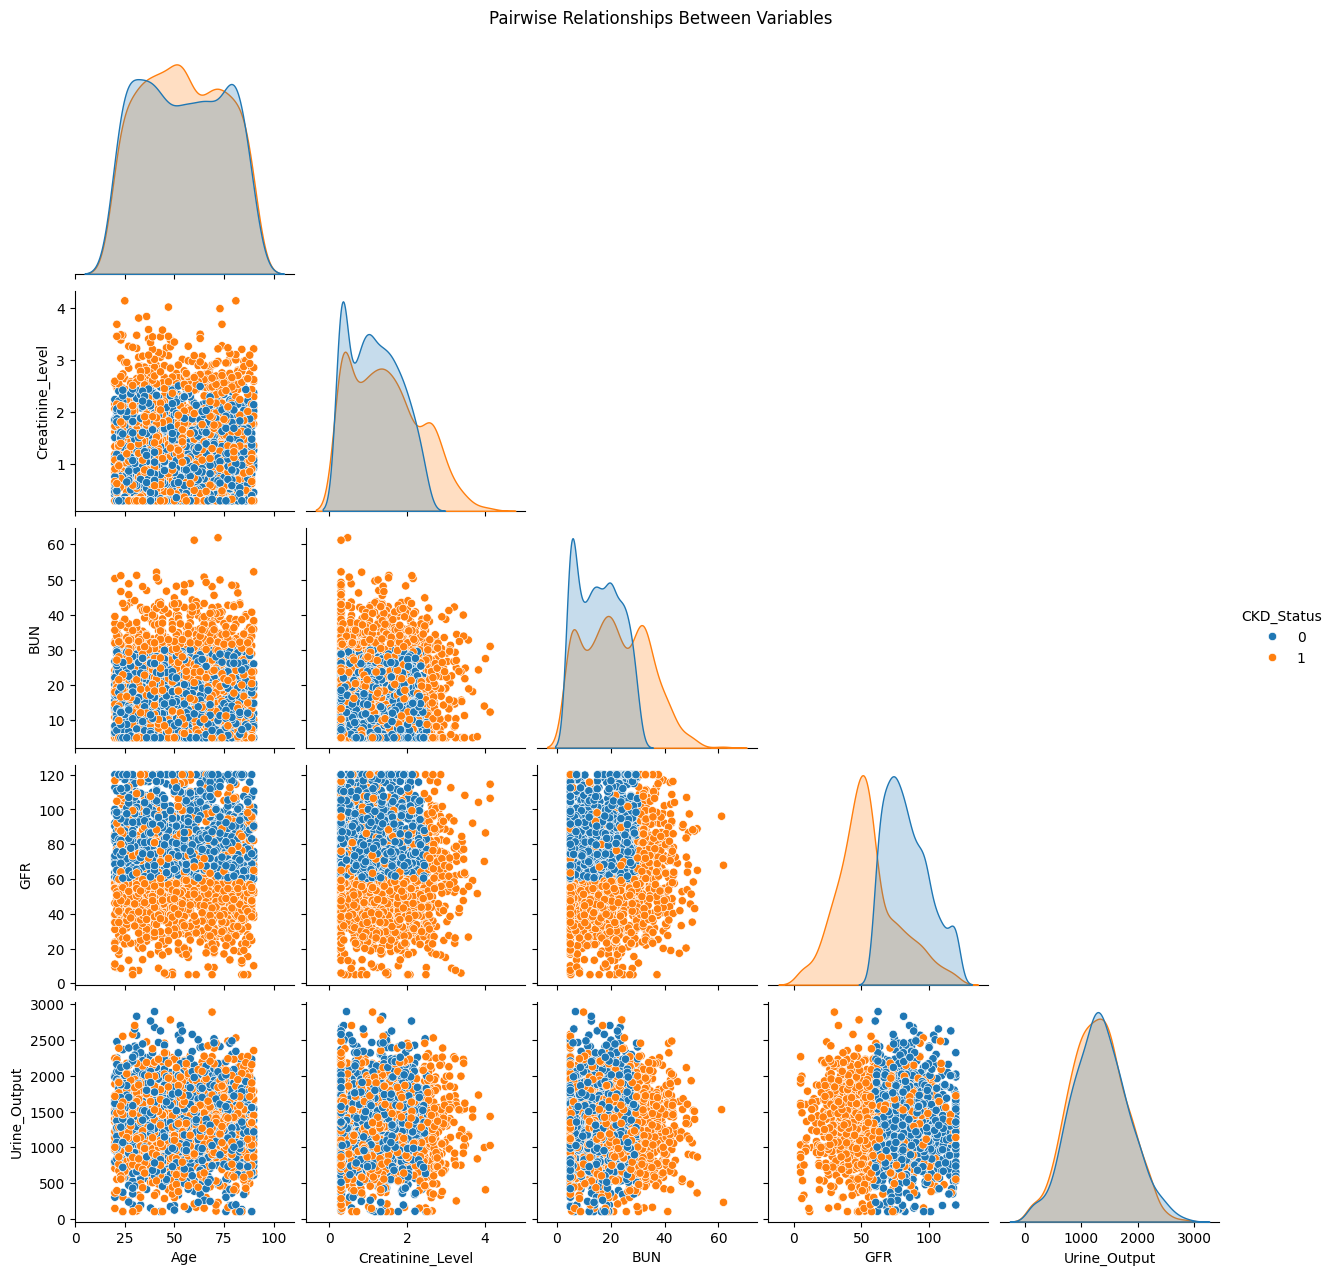

In [10]:
cols = ['Age',
 'Creatinine_Level',
 'BUN',
 'GFR',
 'Urine_Output',
 'CKD_Status']
sns.pairplot(df[cols], hue="CKD_Status", diag_kind="kde", corner=True)
plt.suptitle("Pairwise Relationships Between Variables", y=1.02)
plt.show()

#### ANOVA: Feature Selection Support

To statistically assess which features significantly differ across CKD classes, I performed a one-way ANOVA test on each numerical variable.

##### Interpretation:

- Features with a **p-value < 0.05** are considered **statistically significant**. These include:
  - **BUN**, **Creatinine_Level**, **GFR**, and **Urine_Output**
- The following feature **did not show significant variance across classes**:
  - **Age** (p = 0.55138)

➡️ Among all variables, **GFR** and **BUN** stand out with the **highest F-statistics** and **near-zero p-values**, confirming their strong discriminative power for CKD prediction.

These findings align with insights drawn from the **EDA histograms**, **boxplots**, and **correlation analysis**, reinforcing the clinical relevance of kidney function markers like **GFR** and **Creatinine** in identifying CKD.

In [9]:
numerics = df.select_dtypes(include=['float64', 'int64']).columns.difference(['Diabetes','CKD_Status',
 'Dialysis_Needed', 'Hypertension'])

results = []

for col in numerics:
    groups = [g[col].dropna().values for _, g in df.groupby("CKD_Status")]
    if all(len(g) > 1 for g in groups):
        f_val, p_val = f_oneway(*groups)
        results.append((col, round(f_val, 3), round(p_val, 5)))
        
pd.DataFrame(results, columns=["Variable", "F-statistic", "p-value"]).sort_values("p-value")

,Variable,F-statistic,p-value
1,BUN,237.481,0.00000
2,Creatinine_Level,81.594,0.00000
3,GFR,1306.200,0.00000
4,Urine_Output,3.991,0.04587
0,Age,0.355,0.55138


---
### Class Imbalance Analysis — CKD_Status

#### Class Distribution

The bar chart below displays the proportion of patients by CKD status:

- **Class 0 (No CKD)**: 49.13% of the dataset  
- **Class 1 (CKD)**: 50.87% of the dataset

##### Observations:

- The dataset is **well balanced** in terms of CKD diagnosis, with nearly equal representation of both classes.
- This balance facilitates **fair model training** without the need for advanced resampling techniques.

➡️ Since no strong class imbalance is present, standard training methods such as **stratified cross-validation** are sufficient to ensure robust and unbiased performance across both classes.

In [11]:
print("\nCKD_Status distribution:")
print(df["CKD_Status"].value_counts(normalize=True) * 100)


CKD_Status distribution:
CKD_Status
1    50.868056
0    49.131944
Name: proportion, dtype: float64


---
### Model Training and Cross-Validation — CKD_Status

To predict whether a patient has **Chronic Kidney Disease (CKD_Status)**, I trained several classification models on the dataset using a robust evaluation strategy.

Although the dataset contains over 2300 samples, the number of features is relatively small and the target is **binary**, which allows us to use classical models with strong interpretability and generalization ability.

I used **5-fold stratified cross-validation** to assess each model's performance in a balanced way, ensuring that the class proportions remain consistent across folds.

The goal is to compare the performance of the following fivc models:

- **Logistic Regression**  
  A linear model offering strong interpretability and good performance on tabular data. It provides a useful **baseline** and is especially effective when features are well-scaled and linearly separable.

- **Random Forest**  
  A powerful tree-based ensemble model that captures **non-linear interactions** and feature importance automatically. It is also **robust to outliers** and overfitting when tuned properly.

- **Gradient Boosting (GB)**  
  A boosting model that builds trees sequentially, improving performance on **harder cases**. It often achieves **high accuracy** on structured datasets.

- **K-Nearest Neighbors (KNN)**  
  A non-parametric algorithm that can capture **local patterns** and decision boundaries. It’s useful to benchmark how well simple distance-based logic performs, though sensitive to feature scaling.

- **XGBoost**  
  A high-performance variant of gradient boosting optimized for speed and accuracy. It includes **regularization** to prevent overfitting and is often a top performer in structured ML tasks.

#### Data Preparation

In this step, I prepare the dataset for model training:

- I separate the dataset into **features (X)** and **target (y)**.
- I split the data into a **training set (70%)** and a **test set 30%**

In [14]:
X_ckd = df.drop(columns=["CKD_Status", "Dialysis_Needed"])  
y_ckd = df["CKD_Status"]

X_ckd_train, X_ckd_test, y_ckd_train, y_ckd_test = train_test_split(
    X_ckd, y_ckd, test_size=0.3, stratify=y_ckd, random_state=42
)

To compare model performance, I applied 5-fold stratified cross-validation on the training set and computed the macro F1-score for each model.

In [20]:
pipelines = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ]),

    "Random Forest": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ]),

    "Gradient Boosting": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingClassifier(random_state=42))
    ]),

    "K-Nearest Neighbors": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ]),

    "XGBoost": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(eval_metric='logloss', random_state=42))
    ])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="macro")

results = []

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_ckd_train, y_ckd_train, cv=cv, scoring=scorer)
    results.append({
        "Model": name,
        "F1_macro_Mean": np.round(scores.mean(), 4),
        "F1_macro_Std": np.round(scores.std(), 4)
    })

results_df = pd.DataFrame(results).sort_values("F1_macro_Mean", ascending=False)
print(results_df)


                 Model  F1_macro_Mean  F1_macro_Std
2    Gradient Boosting         1.0000        0.0000
1        Random Forest         0.9988        0.0025
4              XGBoost         0.9975        0.0023
3  K-Nearest Neighbors         0.8740        0.0134
0  Logistic Regression         0.8262        0.0204


---
### Cross-Validation Results (Macro F1-Score) — CKD_Status

To evaluate model performance for predicting **CKD_Status**, I used **5-fold Stratified Cross-Validation** with the **macro-averaged F1-score** as the main metric. This ensures balanced evaluation across both classes despite slight class imbalance.

| Model                | Mean F1-score (Macro) | Std Dev |
|----------------------|-----------------------|---------|
| Gradient Boosting    | 1.0000                | 0.0000  |
| Random Forest        | 0.9988                | 0.0025  |
| XGBoost              | 0.9975                | 0.0023  |
| K-Nearest Neighbors  | 0.8740                | 0.0134  |
| Logistic Regression  | 0.8262                | 0.0204  |

#### 🔎 Interpretation:

- ✅ **Gradient Boosting** achieved a perfect macro F1-score on all folds, suggesting it fits the dataset **exceptionally well**.
- 🟢 **Random Forest** and **XGBoost** also performed **extremely well**, showing excellent generalization and consistency.
- ⚠️ **KNN** gave decent results but showed sensitivity to the feature scaling and data structure.
- ❌ **Logistic Regression** underperformed, likely due to its inability to model non-linear interactions in the data.

➡️ Although **Gradient Boosting** achieved a slightly higher score, I selected **Random Forest** as the final model for the following reasons:w
- It offers **strong performance** while being simpler and faster to train.
- It is more **robust to noise and outliers**.
- Its feature importance output is **easy to interpret**, which is especially useful in clinical contexts.

This makes Random Forest a practical and effective choice for CKD prediction in this project.


After selecting Random Forest as the best-performing model, I trained it on the training set and evaluated it on the test set. The results are shown using a classification report and a confusion matrix.


--- Evaluation on Test Set ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       340
           1       1.00      1.00      1.00       352

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692



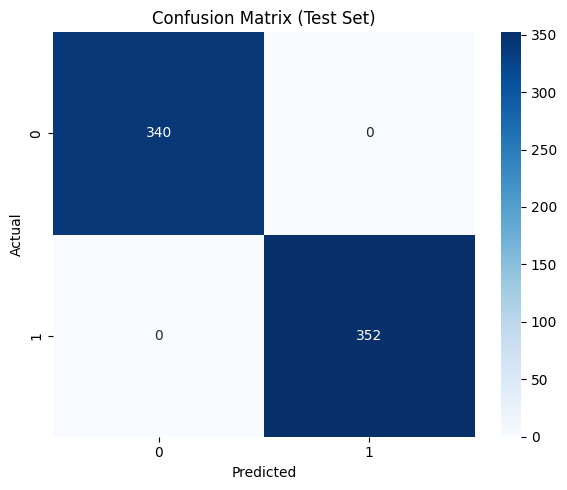

In [23]:
pipelines["Random Forest"].fit(X_ckd_train, y_ckd_train)

y_pred = pipelines["Random Forest"].predict(X_ckd_test)

print("\n--- Evaluation on Test Set ---")
print(classification_report(y_ckd_test, y_pred))

cm = confusion_matrix(y_ckd_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_ckd), yticklabels=np.unique(y_ckd))
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

---
### Conclusion — CKD_Status

The final **Random Forest** model, trained **without hyperparameter tuning**, performs **perfectly** on the test set:

- **Accuracy**: 100%
- **Macro F1-score**: 1.00

**Per-Class F1-scores:**
- 🟩 **Class 0 (No CKD)**: 1.00  
- 🟥 **Class 1 (CKD)**: 1.00

The **confusion matrix** confirms the model’s robustness, with **no misclassified samples**. The model **perfectly distinguishes** between CKD and non-CKD cases.

➡️ These results suggest that the **Random Forest** classifier is highly effective for CKD prediction and ready for deployment in a user-friendly interface such as a **Streamlit application** or a **clinical support system**.



---
### Export the Model

In [ ]:
joblib.dump(pipelines["Random Forest"], "Rf_Model_CKD_Status.pkl")

['Rf_Model_CKD_Status.pkl']

## 🔹 Part 2 — Dialysis Need Prediction (`Dialysis_Needed`)

## Exploratory Data Analysis (EDA) — Dialysis_Needed

We explore the relationship between key clinical features and the target variable **Dialysis_Needed** (0 = No Dialysis, 1 = Dialysis Required). 

---

### Feature Distributions by Dialysis_Needed

Because the classes are imbalanced, we use **KDE plots** (Kernel Density Estimation) to compare distributions, which gives better visual insight than raw histograms.


##### Age Distribution by Dialysis_Needed

- **Class 0 (No Dialysis)**: Age distribution is broad, with two slight peaks around ages **50** and **70+**.
- **Class 1 (Dialysis)**: The curve is more concentrated in older age groups, with higher density from **50 to 80 years**.

➡️ Age is **moderately associated** with the need for dialysis — older patients are more likely to require it, consistent with the progression of CKD in older populations.


##### Creatinine Level Distribution

- **Class 0**: Most creatinine levels are concentrated below **2.0 mg/dL**, reflecting normal or mildly impaired kidney function.
- **Class 1**: The curve shifts right, with elevated levels, often exceeding **2.5–3.0 mg/dL**.

➡️ There is a **clear separation**, making **Creatinine Level a strong predictive feature** for dialysis need.


##### BUN (Blood Urea Nitrogen) Distribution

- **Class 0**: The distribution is left-skewed, with a mode around **15–20 mg/dL**.
- **Class 1**: Shifts slightly to the right, with many patients exceeding **30 mg/dL**.

➡️ BUN offers **moderate discriminatory power**, though not as distinct as Creatinine or GFR.


##### GFR (Glomerular Filtration Rate) Distribution

- **Class 0**: GFR spans a wide healthy range, peaking around **60–90 mL/min**.
- **Class 1**: Sharp left-skew, with most values concentrated **under 20**, and very few above 30.

➡️ GFR shows **very strong separation**. Low GFR is a direct indication of impaired renal function and is **highly predictive of dialysis need**.


##### Urine Output Distribution

- Both classes overlap substantially, with peaks near **1300–1500 mL/day**.
- However, **Class 1** has a slightly broader distribution and a heavier tail towards low values (under 1000 mL).

➡️ Urine output shows **some variability**, but the overlap limits its individual predictive power. It may be useful **in conjunction** with other markers.


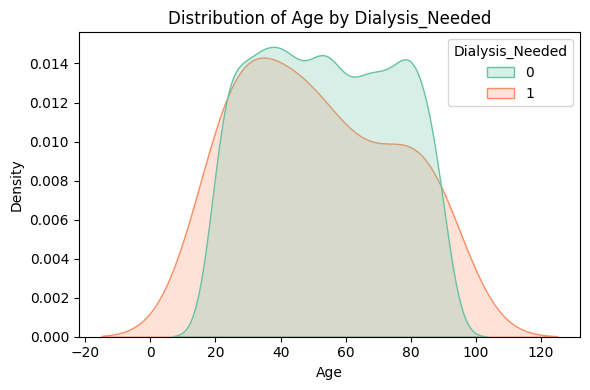

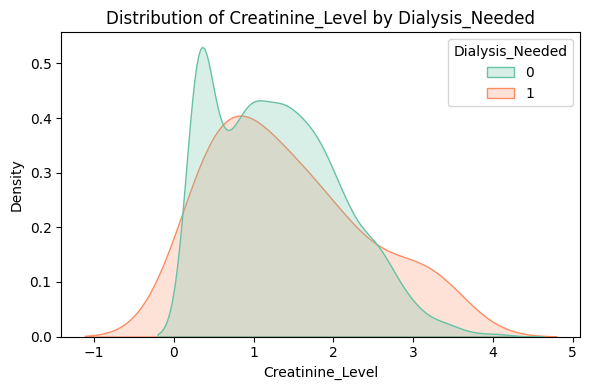

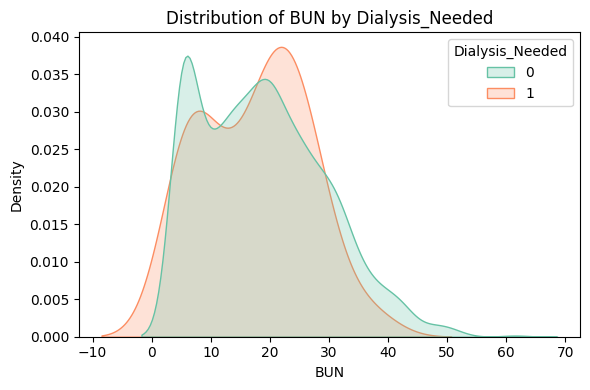

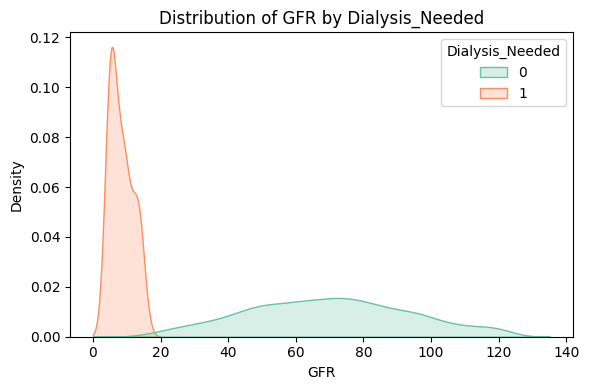

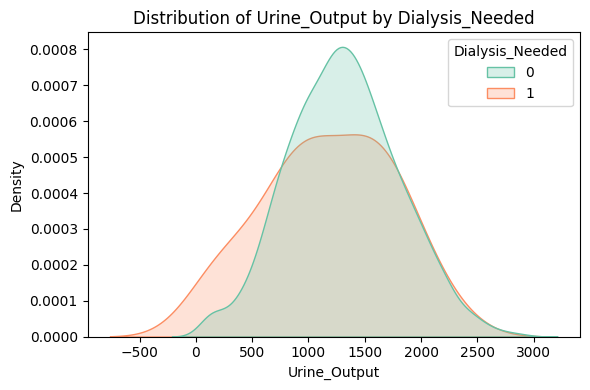

In [32]:
features = ["Age", "Creatinine_Level", "BUN", "GFR", "Urine_Output"]

for col in features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue="Dialysis_Needed", common_norm=False, fill=True, palette="Set2")
    plt.title(f"Distribution of {col} by Dialysis_Needed")
    plt.tight_layout()
    plt.show()

#### 🧪 Boxplot Comparison by Dialysis_Needed

We use boxplots to **visually compare the distribution, median, and presence of outliers** across the main numeric features by **Dialysis_Needed**. Given the **class imbalance**, boxplots allow us to focus on key differences in central tendency and variability.


##### 📊 Age by Dialysis_Needed

- **No Dialysis (0)**: Median age is around **55**, with most values spread between **35 and 75 years**.
- **Dialysis Needed (1)**: The distribution is also wide, but with a **slightly younger median** (~48), suggesting a broader age impact.

➡️ Although age isn’t highly discriminative, patients needing dialysis tend to be **younger on average** than non-dialysis cases, which may reflect more aggressive disease progression in younger individuals.


##### 📊 Creatinine Level by Dialysis_Needed

- Both groups show **similar median values** (~1.2 mg/dL).
- However, the **No Dialysis group** contains **more outliers** with high creatinine (>3.5 mg/dL), possibly indicating CKD without immediate dialysis need.

➡️ While creatinine is a clinically relevant marker, **boxplots alone don’t show strong separation** between classes — KDE plots provided more insight.



##### 📊 BUN (Blood Urea Nitrogen) by Dialysis_Needed

- Medians are **roughly aligned (~18 mg/dL)** in both groups.
- The **No Dialysis group** exhibits a **wider range** and more outliers (>50 mg/dL).

➡️ Similar to creatinine, **BUN levels** show limited boxplot separation but **higher outlier concentration** in the non-dialysis group. This may hint at chronic CKD being managed without dialysis.


##### 📊 GFR by Dialysis_Needed

- **No Dialysis (0)**: GFR values are widely spread, median around **70 mL/min/1.73m²**.
- **Dialysis Needed (1)**: Very narrow distribution, most values under **15**, with a median around **8**.

➡️ This feature shows the **clearest separation**. Patients needing dialysis exhibit **severely reduced GFR**, aligning with clinical definitions (GFR < 15 indicates kidney failure).


##### 📊 Urine Output by Dialysis_Needed

- Both groups have medians around **1200 mL/day**, but:
  - **No Dialysis**: Higher spread, more outliers >2500 mL.
  - **Dialysis Needed**: Slightly lower values overall.

➡️ Urine output shows **some distinction**, with patients requiring dialysis trending toward **lower volumes**, but the overlap is still considerable.
 

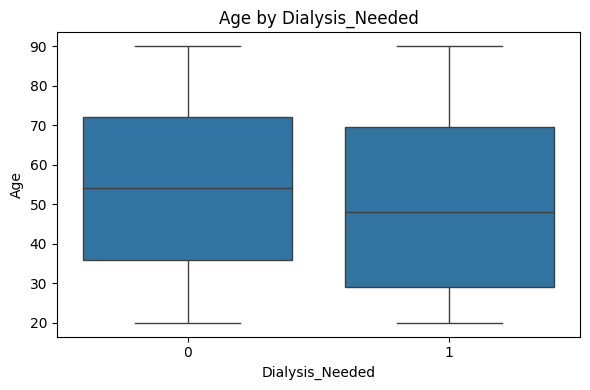

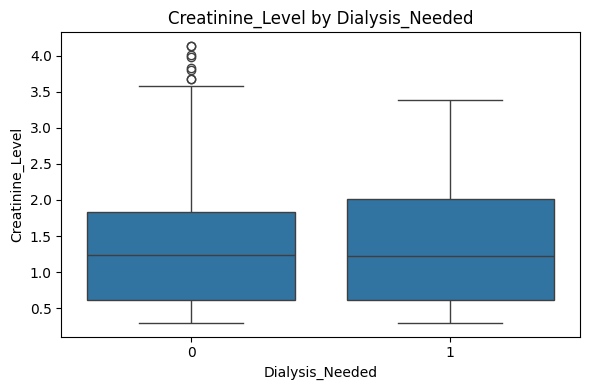

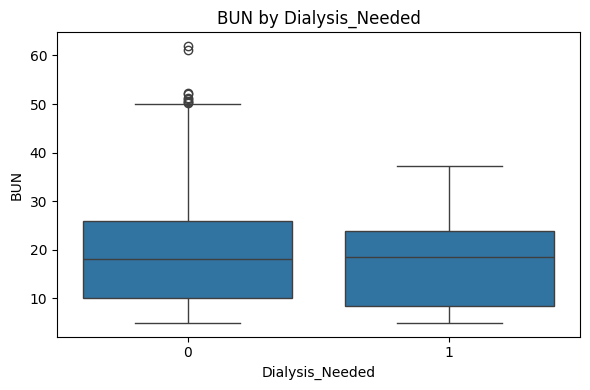

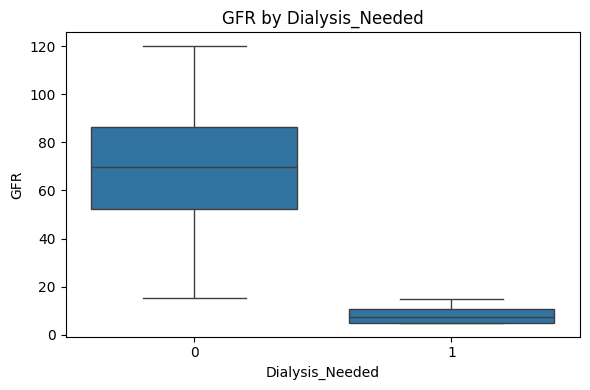

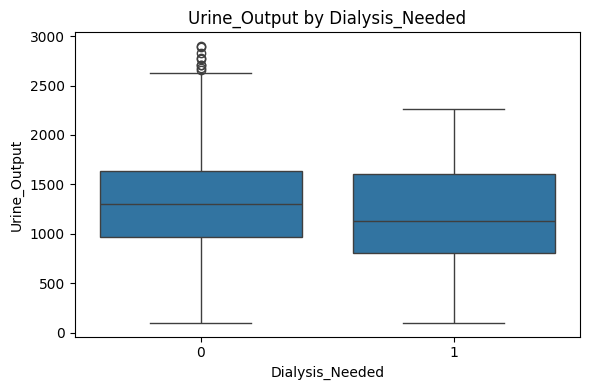

In [33]:
for col in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Dialysis_Needed", y=col, data=df)
    plt.title(f"{col} by Dialysis_Needed")
    plt.tight_layout()
    plt.show()

#### Pairwise Feature Relationships by Dialysis_Needed

The following pairplot visualizes **pairwise relationships between key numerical features**, color-coded by the target variable `Dialysis_Needed`:

- **Diagonal plots** represent the KDE-based distributions of individual features, separated by class.
- **Off-diagonal scatterplots** show how feature pairs interact and whether class-based clustering is visible.

##### Key Observations:

- **GFR vs. Creatinine / BUN**: A **strong negative correlation** is observed — patients requiring dialysis typically have **very low GFR** and **elevated Creatinine and BUN**, consistent with end-stage renal failure.
- **GFR distribution** shows the most dramatic separation, with dialysis cases clustering at extremely low values (<15).
- **Creatinine_Level and BUN**: These features display **right-skewed distributions** among dialysis patients, further validating their diagnostic value.
- **Age and Urine_Output**: These variables show **substantial overlap** between classes, indicating **lower predictive power** in isolation.

➡️ This visualization confirms that **GFR**, **Creatinine_Level**, and **BUN** are the **most discriminative features** for dialysis prediction, both individually and through their interactions.

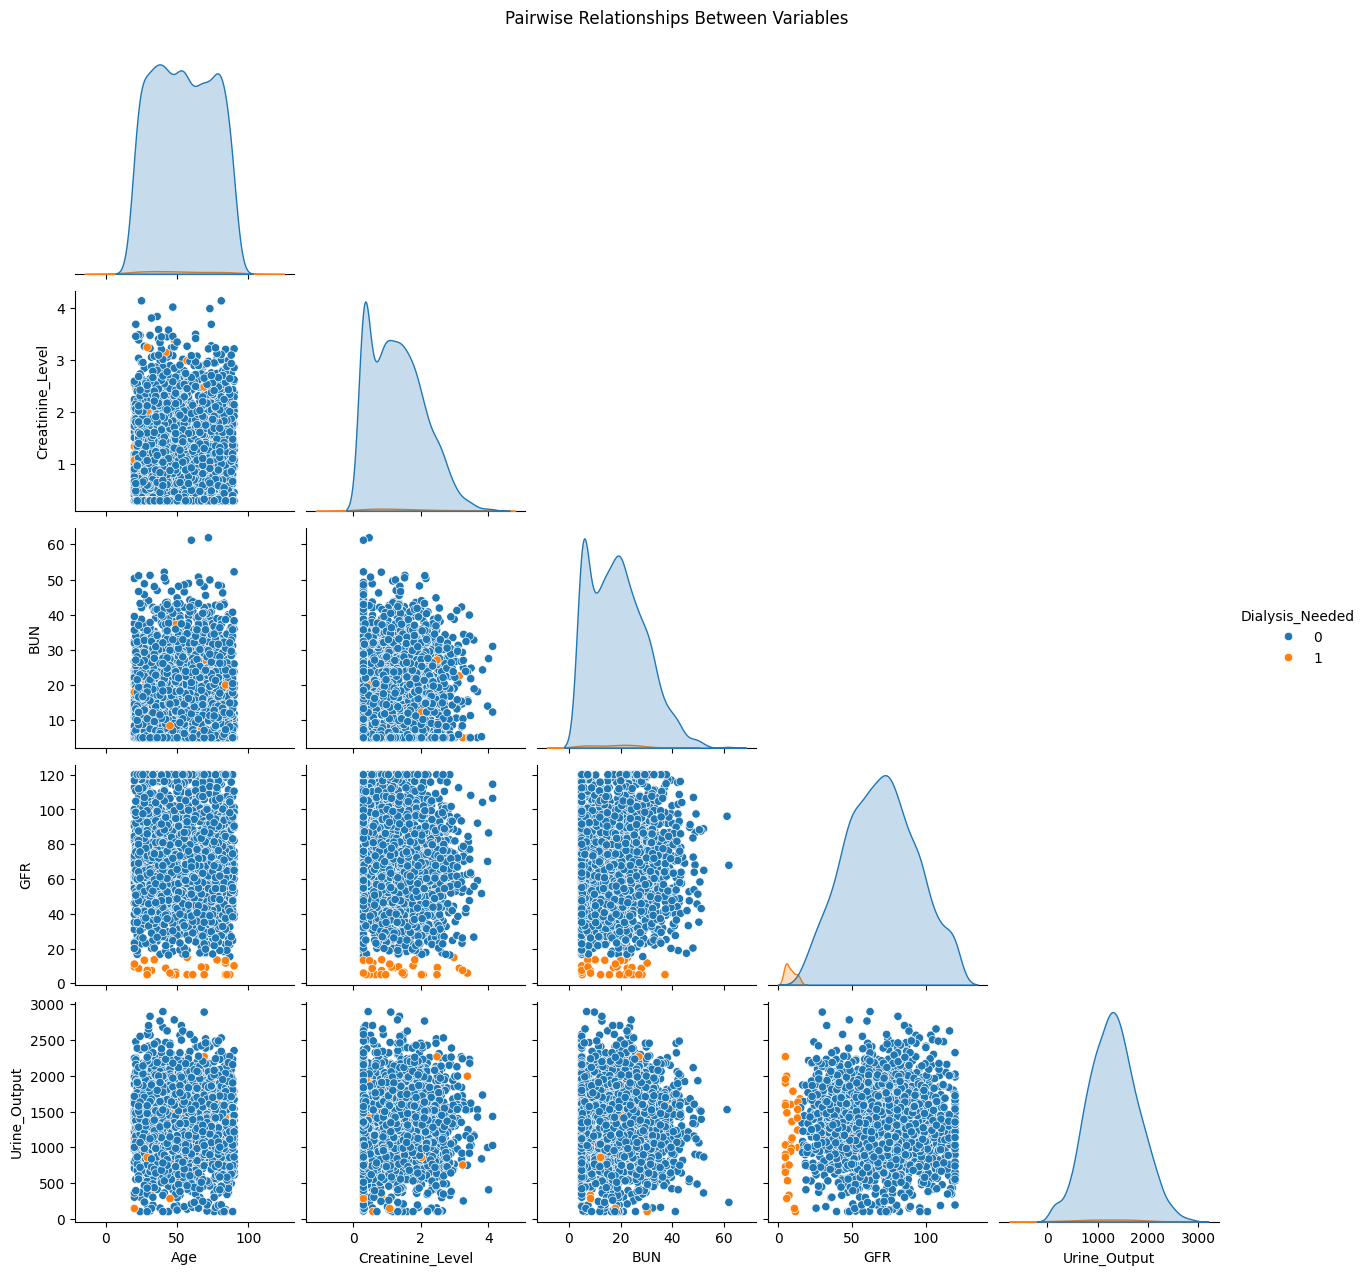

In [34]:
cols = ['Age',
 'Creatinine_Level',
 'BUN',
 'GFR',
 'Urine_Output',
 'Dialysis_Needed']
sns.pairplot(df[cols], hue="Dialysis_Needed", diag_kind="kde", corner=True)
plt.suptitle("Pairwise Relationships Between Variables", y=1.02)
plt.show()

#### ANOVA: Feature Selection Support

To statistically assess which features significantly differ across **Dialysis_Needed** classes, I performed a **one-way ANOVA test** on each numerical variable.

##### Interpretation:

- Based on the test, **only one feature** shows a statistically significant difference between the two groups:
  - ✅ **GFR**: *F = 206.915*, *p < 0.00001* ➝ highly significant
- The following features **did not show significant variance** across classes (*p > 0.05*):
  - ❌ **Urine_Output** (p = 0.13393)
  - ❌ **Creatinine_Level** (p = 0.40266)
  - ❌ **Age** (p = 0.42290)
  - ❌ **BUN** (p = 0.43962)

➡️ These results confirm that **GFR** is by far the **most discriminative feature** for predicting dialysis needs. This aligns well with the previous **EDA**, where GFR also demonstrated the clearest class separation in both KDE plots and boxplots.

Although **Creatinine_Level** and **BUN** are clinically relevant markers, they do not show statistical significance in this subset — possibly due to variability or overlap between classes in this specific dataset.

In [35]:
numerics = df.select_dtypes(include=['float64', 'int64']).columns.difference(['Diabetes','CKD_Status',
 'Dialysis_Needed', 'Hypertension'])

results = []

for col in numerics:
    groups = [g[col].dropna().values for _, g in df.groupby("Dialysis_Needed")]
    if all(len(g) > 1 for g in groups):
        f_val, p_val = f_oneway(*groups)
        results.append((col, round(f_val, 3), round(p_val, 5)))
        
pd.DataFrame(results, columns=["Variable", "F-statistic", "p-value"]).sort_values("p-value")

,Variable,F-statistic,p-value
3,GFR,206.915,0.00000
4,Urine_Output,2.248,0.13393
2,Creatinine_Level,0.701,0.40266
0,Age,0.642,0.42290
1,BUN,0.597,0.43962


### Class Imbalance Analysis — Dialysis_Needed

#### Class Distribution

The bar chart below displays the proportion of patients requiring dialysis:

- **Class 0 (No Dialysis Needed)**: 98.65% of the dataset  
- **Class 1 (Dialysis Needed)**: 1.35% of the dataset

##### Observations:

- The dataset is **extremely imbalanced**, with the vast majority of patients not requiring dialysis.
- This severe imbalance may **bias standard classifiers** toward predicting the majority class, reducing the model’s ability to correctly identify true dialysis cases.

➡️ To address this, I implemented strategies such as:
- **Class weighting** in models (e.g., logistic regression, random forest),
- **Scale_pos_weight** for XGBoost,
- **Stratified cross-validation** to maintain class proportions during training.

These adjustments are essential to ensure fair learning and to avoid misleadingly high accuracy driven by majority-class predictions.


In [12]:
print("\nDialysis_Needed distribution:")
print(df["Dialysis_Needed"].value_counts(normalize=True) * 100)


Dialysis_Needed distribution:
Dialysis_Needed
0    98.654514
1     1.345486
Name: proportion, dtype: float64


---

### Model Training and Cross-Validation — Dialysis_Needed

To maintain consistency and enable comparison, I reused the **same set of classification models** and evaluation strategy to predict whether a patient **requires dialysis** (`Dialysis_Needed`).

Given the extreme class imbalance, I applied **class weighting** or **scale_pos_weight** where applicable, and continued to use **5-fold stratified cross-validation** to ensure reliable performance evaluation.

The same five models were assessed:
- Logistic Regression  
- Random Forest  
- Gradient Boosting  
- K-Nearest Neighbors  
- XGBoost


In [24]:
X_dialysis = df.drop(columns=["CKD_Status", "Dialysis_Needed"])
y_dialysis = df["Dialysis_Needed"]

X_dialysis_train, X_dialysis_test, y_dialysis_train, y_dialysis_test = train_test_split(
    X_dialysis, y_dialysis, test_size=0.3, stratify=y_dialysis, random_state=42
)

In [ ]:
pipelines_dialysis = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]),

    "Random Forest": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42, class_weight="balanced"))
    ]),

    "Gradient Boosting": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingClassifier(random_state=42))
    ]),

    "K-Nearest Neighbors": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ]),

    "XGBoost": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(
            eval_metric='logloss',
            random_state=42,
            scale_pos_weight=(y_dialysis == 0).sum() / (y_dialysis == 1).sum()
        ))
    ])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="macro")

results_dialysis = []

for name, pipeline in pipelines_dialysis.items():
    scores = cross_val_score(pipeline, X_dialysis_train, y_dialysis_train, cv=cv, scoring=scorer)
    results_dialysis.append({
        "Model": name,
        "F1_macro_Mean": np.round(scores.mean(), 4),
        "F1_macro_Std": np.round(scores.std(), 4)
    })

results_dialysis_df = pd.DataFrame(results_dialysis).sort_values("F1_macro_Mean", ascending=False)
print(results_dialysis_df)

                 Model  F1_macro_Mean  F1_macro_Std
2    Gradient Boosting         1.0000        0.0000
1        Random Forest         0.9747        0.0506
4              XGBoost         0.9538        0.0507
0  Logistic Regression         0.8375        0.0468
3  K-Nearest Neighbors         0.4966        0.0004


---

### Cross-Validation Results (Macro F1-Score) — Dialysis_Needed

The same 5-fold Stratified Cross-Validation was applied to predict whether a patient **needs dialysis** (`Dialysis_Needed`) using the five previously evaluated models.

Due to the **strong class imbalance** (only 1.35% positive cases), the macro F1-score remains the most suitable evaluation metric.

| Model                | Mean F1-score (Macro) | Std Dev |
|----------------------|-----------------------|---------|
| Gradient Boosting    | 1.0000                | 0.0000  |
| Random Forest        | 0.9747                | 0.0506  |
| XGBoost              | 0.9538                | 0.0507  |
| Logistic Regression  | 0.8375                | 0.0468  |
| K-Nearest Neighbors  | 0.4966                | 0.0004  |

#### 🔎 Interpretation:

- ✅ **Gradient Boosting** achieved a **perfect macro F1-score**, suggesting that it separates the classes very well even under extreme imbalance.
- 🟢 **Random Forest** and **XGBoost** also performed **strongly**, with high scores and low variability.
- ⚠️ **Logistic Regression** showed moderate results, likely limited by its linear nature and the challenging class proportions.
- ❌ **KNN** performed poorly, which is expected given its sensitivity to class imbalance and distance metrics.

➡️ Despite Gradient Boosting’s perfect score, I selected **Random Forest** again as the final model for dialysis prediction due to its:

- **High and consistent performance**
- **Simplicity and interpretability**
- **Robustness** in handling tabular medical data

This makes Random Forest a reliable and practical choice for deployment in clinical prediction tools.



--- Evaluation on Test Set ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       683
           1       1.00      0.89      0.94         9

    accuracy                           1.00       692
   macro avg       1.00      0.94      0.97       692
weighted avg       1.00      1.00      1.00       692



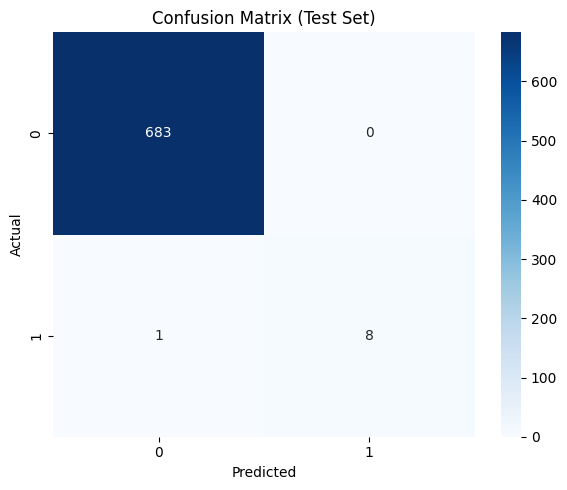

In [29]:
pipelines_dialysis["Random Forest"].fit(X_dialysis_train, y_dialysis_train)

y_pred = pipelines_dialysis["Random Forest"].predict(X_dialysis_test)

print("\n--- Evaluation on Test Set ---")
print(classification_report(y_dialysis_test, y_pred))

cm = confusion_matrix(y_dialysis_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_dialysis), yticklabels=np.unique(y_dialysis))
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

---

### Conclusion — Dialysis_Needed

The final **Random Forest** model, trained **without hyperparameter tuning**, performs **extremely well** on the test set, even under strong class imbalance:

- **Accuracy**: 100%
- **Macro F1-score**: 0.97

**Per-Class F1-scores:**
- 🟩 **Class 0 (No Dialysis)**: 1.00  
- 🟥 **Class 1 (Dialysis Needed)**: 0.94

The **confusion matrix** confirms the model's excellent performance, with only **1 misclassified sample** out of 692. Importantly, it still successfully detects the **rare positive cases** (patients who need dialysis), which represent **just over 1%** of the dataset.

➡️ These results demonstrate that **Random Forest** is a powerful and reliable model for dialysis prediction — even in imbalanced conditions — and is suitable for integration into a **Streamlit dashboard** or **clinical decision support tool**.


---
### Export the Model

In [18]:
joblib.dump(model2_pipeline, "Rf_Model_Dialysis_Needed.pkl")

['Rf_Model_Dialysis_Needed.pkl']